,kappa,m_S,m_bar,chi,chi_bar,p,sparsity
0,0.000010,0.993291,0.993002,25572.336909,25839.792780,0.467093,0.467093
1,0.000023,0.993285,0.993345,25724.848059,25874.054199,0.407452,0.407452
2,0.000030,0.990543,0.989888,25739.086437,26062.716147,0.618398,0.618398
3,0.000051,0.993841,0.993687,25643.489855,25830.208499,0.530670,0.530670
4,0.000091,0.975125,0.974050,26370.092097,26504.021191,0.473520,0.473520


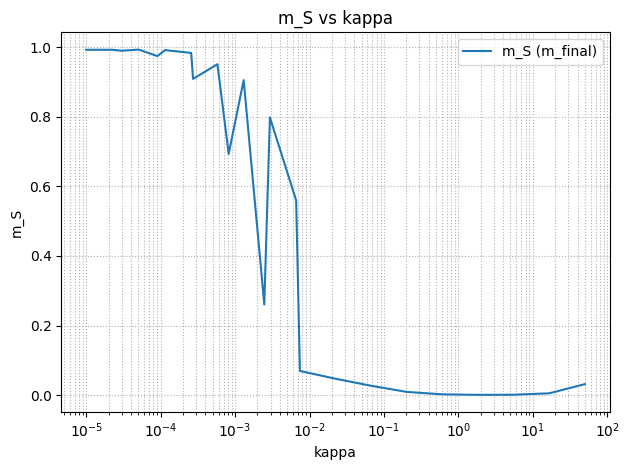

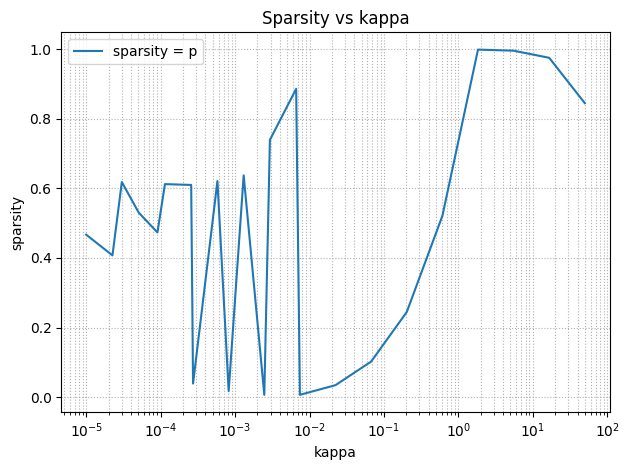

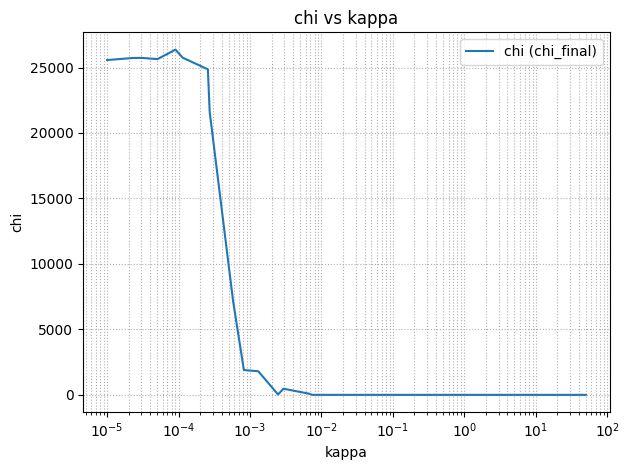

In [1]:
# --- Configure this to point at your results directory ---
DATA_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d30k4_diagosntic4_mix3"

# If you want "sparsity" to mean 1 - p instead of p, set this to '1-p'
SPARSITY_MODE = 'p'   # options: 'p' or '1-p'

# ---------------------------------------------------------

import os, json, glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_results(data_dir: str) -> pd.DataFrame:
    # Grab all JSONs that look like your saved results
    pattern = str(Path(data_dir) / "**" / "saem_mix_result_*.json")
    files = glob.glob(pattern, recursive=True)
    if not files:
        raise FileNotFoundError(f"No result JSONs found under: {data_dir}")

    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            # Only keep rows that have the essentials
            if all(k in obj for k in ("kappa", "m_final", "chi_final", "p_final")):
                rows.append({
                    "kappa": float(obj["kappa"]),
                    "m_S": float(obj["m_final"]),   # treat m_S as m_final
                    "m_bar": float(obj.get("m_bar", np.nan)),
                    "chi": float(obj["chi_final"]),
                    "chi_bar": float(obj.get("chi_bar", np.nan)),
                    "p": float(obj["p_final"]),
                    "path": fp
                })
        except Exception as e:
            print(f"Skipping {fp}: {e}")

    if not rows:
        raise RuntimeError("Found files, but none had the expected fields.")
    df = pd.DataFrame(rows)

    # If multiple files share the same kappa, average them (or choose another rule if you prefer)
    df = (df
          .groupby("kappa", as_index=False)
          .agg({"m_S":"mean","m_bar":"mean","chi":"mean","chi_bar":"mean","p":"mean"}))

    # Sort by kappa (your list is log-spaced)
    df = df.sort_values("kappa").reset_index(drop=True)
    return df

df = load_results(DATA_DIR)

# Add a "sparsity" column based on your preferred definition
if SPARSITY_MODE == '1-p':
    df["sparsity"] = 1.0 - df["p"]
else:
    df["sparsity"] = df["p"]

# Quick peek
display(df.head())

# ---------- Plot: m_S vs kappa ----------
plt.figure()
plt.plot(df["kappa"], df["m_S"], label="m_S (m_final)")
# If you want to see PR-averaged too, uncomment next line:
# plt.plot(df["kappa"], df["m_bar"], linestyle="--", label="m_bar")
plt.xscale("log")
plt.xlabel("kappa")
plt.ylabel("m_S")
plt.title("m_S vs kappa")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()

# ---------- Plot: sparsity vs kappa ----------
plt.figure()
plt.plot(df["kappa"], df["sparsity"], label=f"sparsity = {SPARSITY_MODE}")
plt.xscale("log")
plt.xlabel("kappa")
plt.ylabel("sparsity")
plt.title("Sparsity vs kappa")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()

# ---------- Plot: chi vs kappa ----------
plt.figure()
plt.plot(df["kappa"], df["chi"], label="chi (chi_final)")
# If you want to see PR-averaged too, uncomment next line:
# plt.plot(df["kappa"], df["chi_bar"], linestyle="--", label="chi_bar")
plt.xscale("log")
plt.xlabel("kappa")
plt.ylabel("chi")
plt.title("chi vs kappa")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()


AttributeError: 'XAxis' object has no attribute 'set_majorFormatter'

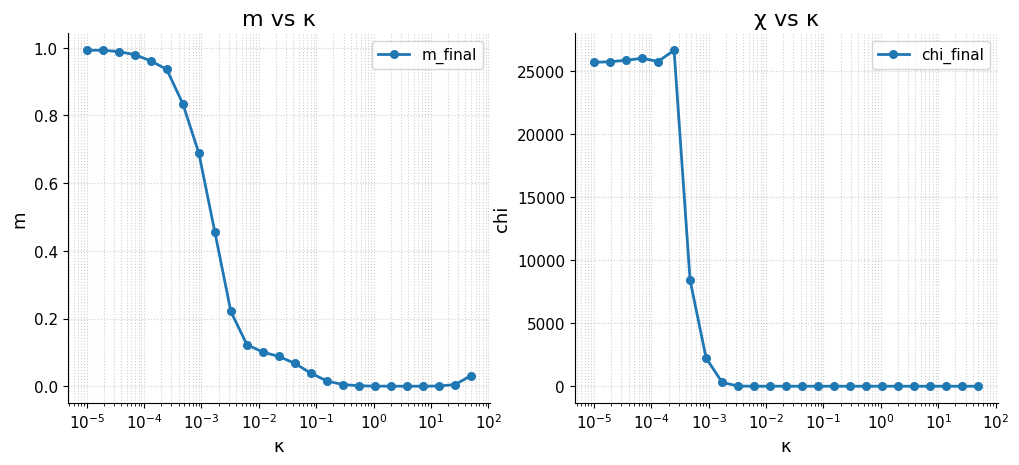

In [7]:
# === CONFIG: set your results dir ===
NOMIX_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d30k4_nospecialst"

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def load_nomix_results(results_dir: str) -> pd.DataFrame:
    files = glob.glob(os.path.join(results_dir, "**", "saem_nomix_result_*.json"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No nomix JSONs found under: {results_dir}")
    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            rows.append({
                "kappa": float(obj["kappa"]),
                "m": float(obj["m_final"]),
                "chi": float(obj["chi_final"]),
                "m_bar": float(obj.get("m_bar", np.nan)),
                "chi_bar": float(obj.get("chi_bar", np.nan)),
                "path": fp
            })
        except Exception as e:
            print(f"Skipping {fp}: {e}")
    df = pd.DataFrame(rows)
    df = (df.groupby("kappa", as_index=False)
            .agg({"m":"mean","chi":"mean","m_bar":"mean","chi_bar":"mean"}))
    return df.sort_values("kappa").reset_index(drop=True)

def plot_nomix(df: pd.DataFrame, logx=True, show_pr=False):
    plt.rcParams.update({
        "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 16,
        "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11
    })
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharex=True)

    # m vs kappa
    axes[0].plot(df["kappa"], df["m"], "-o", label="m_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["m_bar"]).any():
        axes[0].plot(df["kappa"], df["m_bar"], "--o", label="m_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[0].set_ylabel("m")
    axes[0].set_title("m vs κ")
    axes[0].legend()

    # chi vs kappa
    axes[1].plot(df["kappa"], df["chi"], "-o", label="chi_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["chi_bar"]).any():
        axes[1].plot(df["kappa"], df["chi_bar"], "--o", label="chi_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[1].set_ylabel("chi")
    axes[1].set_title("χ vs κ")
    axes[1].legend()

    for ax in axes:
        if logx:
            ax.set_xscale("log")
        ax.set_xlabel("κ")
        ax.grid(True, which="both", linestyle=":", alpha=0.6)
        for s in ("top","right"):
            ax.spines[s].set_visible(False)

    if logx:
        def log_to_tex(v, pos):
            try:
                p = int(np.round(np.log10(v)))
                if np.isclose(10**p, v): return rf"$10^{p}$"
            except: pass
            return ""
        axes[1].xaxis.set_majorFormatter(FuncFormatter(log_to_tex))

    plt.tight_layout()
    plt.show()

# run
df_nomix = load_nomix_results(NOMIX_DIR)
plot_nomix(df_nomix, logx=True, show_pr=False)


AttributeError: 'XAxis' object has no attribute 'set_majorFormatter'

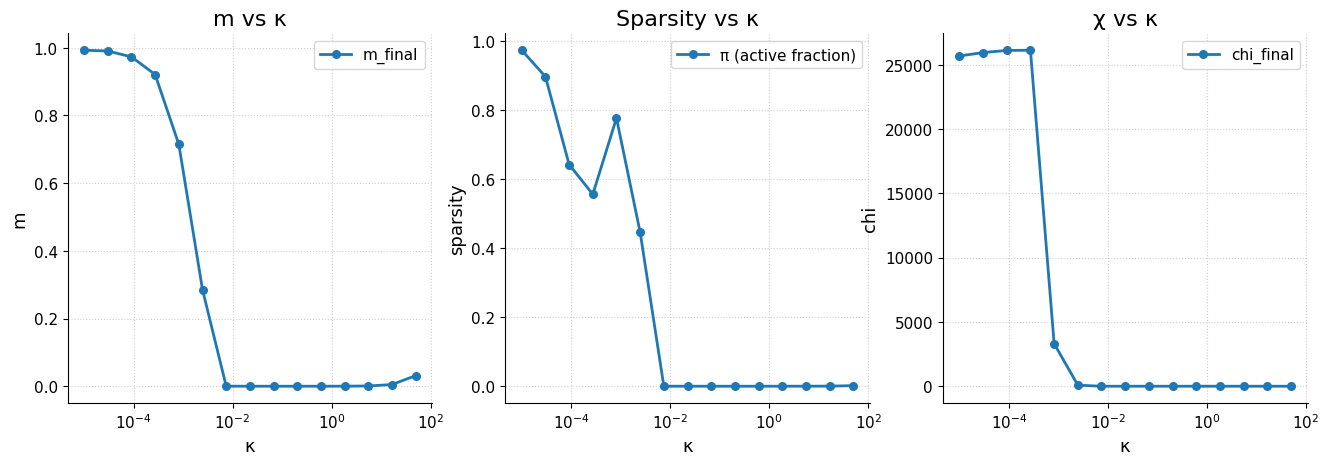

In [8]:
# === CONFIG: set your results dir ===
SPIKESLAB_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d30k4_sparse"

# Choose how to show "sparsity": 'pi' (active fraction) or '1-pi' (inactive fraction)
SPARSITY_MODE = 'pi'   # options: 'pi' or '1-pi'

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def load_spikeslab_results(results_dir: str) -> pd.DataFrame:
    files = glob.glob(os.path.join(results_dir, "**", "saem_spikeslab_result_*.json"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No spikeslab JSONs found under: {results_dir}")
    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            rows.append({
                "kappa": float(obj["kappa"]),
                "m": float(obj["m_final"]),
                "chi": float(obj["chi_final"]),
                "pi": float(obj["pi_final"]),
                "m_bar": float(obj.get("m_bar", np.nan)),
                "chi_bar": float(obj.get("chi_bar", np.nan)),
                "pi_bar": float(obj.get("pi_bar", np.nan)),
                "path": fp
            })
        except Exception as e:
            print(f"Skipping {fp}: {e}")
    df = pd.DataFrame(rows)
    df = (df.groupby("kappa", as_index=False)
            .agg({"m":"mean","chi":"mean","pi":"mean",
                  "m_bar":"mean","chi_bar":"mean","pi_bar":"mean"}))
    return df.sort_values("kappa").reset_index(drop=True)

def plot_spikeslab(df: pd.DataFrame, logx=True, show_pr=False, cmap_name="viridis"):
    plt.rcParams.update({
        "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 16,
        "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11
    })
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharex=True)

    # m vs kappa
    axes[0].plot(df["kappa"], df["m"], "-o", label="m_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["m_bar"]).any():
        axes[0].plot(df["kappa"], df["m_bar"], "--o", label="m_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[0].set_ylabel("m")
    axes[0].set_title("m vs κ")
    axes[0].legend()

    # sparsity (π or 1-π) vs kappa
    if SPARSITY_MODE == '1-pi':
        sparsity = 1.0 - df["pi"].values
        label_main = "1 - π (inactive fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = 1.0 - df["pi_bar"].values
            label_bar  = "1 - π_bar (PR avg)"
    else:
        sparsity = df["pi"].values
        label_main = "π (active fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = df["pi_bar"].values
            label_bar    = "π_bar (PR avg)"

    axes[1].plot(df["kappa"], sparsity, "-o", label=label_main, linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df.get("pi_bar", np.nan)).any():
        axes[1].plot(df["kappa"], sparsity_bar, "--o", label=label_bar, linewidth=1.7, markersize=4.5)
    axes[1].set_ylabel("sparsity")
    axes[1].set_title("Sparsity vs κ")
    axes[1].legend()

    # chi vs kappa
    axes[2].plot(df["kappa"], df["chi"], "-o", label="chi_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["chi_bar"]).any():
        axes[2].plot(df["kappa"], df["chi_bar"], "--o", label="chi_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[2].set_ylabel("chi")
    axes[2].set_title("χ vs κ")
    axes[2].legend()

    for ax in axes:
        if logx:
            ax.set_xscale("log")
        ax.set_xlabel("κ")
        ax.grid(True, which="both", linestyle=":", alpha=0.6)
        for s in ("top","right"):
            ax.spines[s].set_visible(False)

    if logx:
        def log_to_tex(v, pos):
            try:
                p = int(np.round(np.log10(v)))
                if np.isclose(10**p, v): return rf"$10^{p}$"
            except: pass
            return ""
        axes[2].xaxis.set_majorFormatter(FuncFormatter(log_to_tex))

    plt.tight_layout()
    plt.show()

# run
df_spike = load_spikeslab_results(SPIKESLAB_DIR)
plot_spikeslab(df_spike, logx=True, show_pr=False)


AttributeError: 'XAxis' object has no attribute 'set_majorFormatter'

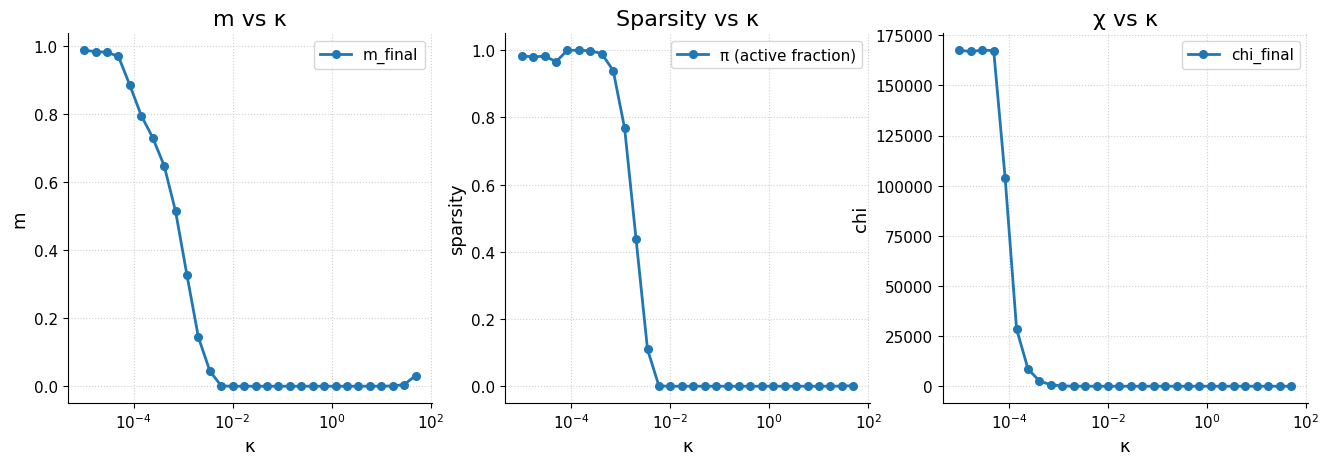

In [1]:
# === CONFIG: set your results dir ===
SPIKESLAB_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d50k6_sparse"

# Choose how to show "sparsity": 'pi' (active fraction) or '1-pi' (inactive fraction)
SPARSITY_MODE = 'pi'   # options: 'pi' or '1-pi'

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def load_spikeslab_results(results_dir: str) -> pd.DataFrame:
    files = glob.glob(os.path.join(results_dir, "**", "saem_spikeslab_result_*.json"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No spikeslab JSONs found under: {results_dir}")
    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            rows.append({
                "kappa": float(obj["kappa"]),
                "m": float(obj["m_final"]),
                "chi": float(obj["chi_final"]),
                "pi": float(obj["pi_final"]),
                "m_bar": float(obj.get("m_bar", np.nan)),
                "chi_bar": float(obj.get("chi_bar", np.nan)),
                "pi_bar": float(obj.get("pi_bar", np.nan)),
                "path": fp
            })
        except Exception as e:
            print(f"Skipping {fp}: {e}")
    df = pd.DataFrame(rows)
    df = (df.groupby("kappa", as_index=False)
            .agg({"m":"mean","chi":"mean","pi":"mean",
                  "m_bar":"mean","chi_bar":"mean","pi_bar":"mean"}))
    return df.sort_values("kappa").reset_index(drop=True)

def plot_spikeslab(df: pd.DataFrame, logx=True, show_pr=False, cmap_name="viridis"):
    plt.rcParams.update({
        "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 16,
        "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11
    })
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharex=True)

    # m vs kappa
    axes[0].plot(df["kappa"], df["m"], "-o", label="m_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["m_bar"]).any():
        axes[0].plot(df["kappa"], df["m_bar"], "--o", label="m_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[0].set_ylabel("m")
    axes[0].set_title("m vs κ")
    axes[0].legend()

    # sparsity (π or 1-π) vs kappa
    if SPARSITY_MODE == '1-pi':
        sparsity = 1.0 - df["pi"].values
        label_main = "1 - π (inactive fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = 1.0 - df["pi_bar"].values
            label_bar  = "1 - π_bar (PR avg)"
    else:
        sparsity = df["pi"].values
        label_main = "π (active fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = df["pi_bar"].values
            label_bar    = "π_bar (PR avg)"

    axes[1].plot(df["kappa"], sparsity, "-o", label=label_main, linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df.get("pi_bar", np.nan)).any():
        axes[1].plot(df["kappa"], sparsity_bar, "--o", label=label_bar, linewidth=1.7, markersize=4.5)
    axes[1].set_ylabel("sparsity")
    axes[1].set_title("Sparsity vs κ")
    axes[1].legend()

    # chi vs kappa
    axes[2].plot(df["kappa"], df["chi"], "-o", label="chi_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["chi_bar"]).any():
        axes[2].plot(df["kappa"], df["chi_bar"], "--o", label="chi_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[2].set_ylabel("chi")
    axes[2].set_title("χ vs κ")
    axes[2].legend()

    for ax in axes:
        if logx:
            ax.set_xscale("log")
        ax.set_xlabel("κ")
        ax.grid(True, which="both", linestyle=":", alpha=0.6)
        for s in ("top","right"):
            ax.spines[s].set_visible(False)

    if logx:
        def log_to_tex(v, pos):
            try:
                p = int(np.round(np.log10(v)))
                if np.isclose(10**p, v): return rf"$10^{p}$"
            except: pass
            return ""
        axes[2].xaxis.set_majorFormatter(FuncFormatter(log_to_tex))

    plt.tight_layout()
    plt.show()

# run
df_spike = load_spikeslab_results(SPIKESLAB_DIR)
plot_spikeslab(df_spike, logx=True, show_pr=False)
